In [1]:
# OBJECTIVE 1: Training a model that predicts hadley cell shared ascending edge based on streamfunction (input) and labeled latitude of
#              the shared ascending edge (output)
# 
# STEP 1: Gather data
#         INPUT= Streamfunc with shape: (time: 540  level: 37  lat: 721) - 3D
#         OUTPUT= Latitude of shared ascending edge, labeled, with shape: (time: 540) - 1D
#
# STEP 2: Shape Data
#         For NN - 1D vector
#         For CNN - 2D matrix
#
# STEP 3: Normalize the Data (Better performance for NNs)
#         1- Take zonal mean of streamfunc
#         2- Find std dev of streamfunc
#         3- Normalize - streamfunc_norm = (streamfunc - streamfunc_mean) / streamfunc_std
#         4- Perform the same action on the labels to ensure values are lebeled correctly
#
# STEP 4: Define classes
#         Define custom PyTorch Dataset class to feed data into NN for training
#
# STEP 5: Split data into training, validation and testing
#
# STEP 6: Choose model architecture based on type of problem
#         Regression Problem - Simple Feedforward Neural Network
#
# STEP 7: Initialize model, loss, optimizer
#         Model type: Feedforward NN
#         Loss Function: MSE
#         Optimizer method: Adam
#
#         STEP 8: Train model (using 60% of data)
#
#         STEP 9: Validate model with loss function (using 30% of data)
#         
#         STEP 10: Test model (using 20% of data)

In [2]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
file_path = "hc-edges-and-streamfunc_monthly-ts_era5_1979-2023.nc"
ds = xr.open_dataset(file_path)

streamfunc = ds["streamfunc"].values  # shape: (time, level, lat)
labels = ds["hc_edge_shared"].values   # shape: (time,)

In [4]:
#Normalize input and labels
streamfunc_mean = np.mean(streamfunc)
streamfunc_std = np.std(streamfunc)
streamfunc_norm = (streamfunc - streamfunc_mean) / streamfunc_std

labels_mean = np.mean(labels)
labels_std = np.std(labels)
labels_norm = (labels - labels_mean) / labels_std

In [5]:
# 3. Define custom dataset
class HadleyDataset(Dataset): # Creating a custom class named HadleyDataset that inherits from PyTorch's base Dataset class.
    
    # PyTorch expects datasets to be in a format it can load in mini-batches, via a DataLoader.
    # To do this, subclass torch.utils.data.Dataset and use __init__ , __len__ , and __getitem__
    
    def __init__(self, X, y): # Specifying how to load/store data
        self.X = torch.tensor(X, dtype=torch.float32).reshape(len(X), -1)  # X is 3D normalized stream function data of shape (N_time, levels, latitudes) → e.g. (540, 37, 721)
                                                                           # reshape X into a 2D array with shape (N_samples, input_dim) input_dim = 37 × 721 = 26677 (FLATTEN)
                                                                           # This makes it suitable for a feedforward neural net, which expects vectors as input

        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # y is 1D normalized label array with shape (540) (ascending edge latitude per time step)
                                                                    # Reshape it into shape (540, 1) using unsqueeze(1) so it’s compatible with the model’s expected output shape
                                                                    # Now self.X is a tensor of shape (N, 26677) & self.y is a tensor of shape (N, 1)
    
    def __len__(self): # Specifying how many total samples there are
        return len(self.y)                                              # Returns the total number of samples (e.g. 540 time steps).
                                                                        # This tells PyTorch how many times to iterate through the dataset during training.

    def __getitem__(self, idx): # Specifying how to access sample 
        return self.X[idx], self.y[idx]                                 # When PyTorch loops through the dataset, this returns the input (X[idx]) and label (y[idx]) for the sample at index idx.
                                                                        # This will help enable batch processing

In [6]:
# 4. Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    streamfunc_norm, labels_norm, test_size=0.4, random_state=42
)
# Splitting streamfunc_norm into training dataset and temporary dataset which will be 
#           split again later into validation and testing datasets
#X_train, y_train: 60% of the data → used to train the model
#X_temp, y_temp: remaining 40% → to be split again into val and test
#random_state=42: makes the split reproducible every time you run the code

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)
#Now you're splitting that 40% temporary set into:
#X_val, y_val: 20% of total data → used to validate the model during training (tuning)
#X_test, y_test: 20% of total data → used to test the model after training
train_dataset = HadleyDataset(X_train, y_train)
val_dataset = HadleyDataset(X_val, y_val)
test_dataset = HadleyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
# 5. Define the model
class HadleyNet(nn.Module):
    def __init__(self, input_dim):
        super(HadleyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

input_dim = streamfunc_norm.shape[1] * streamfunc_norm.shape[2]  # 37 x 721
model = HadleyNet(input_dim)

In [8]:
# 6. Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 50

# 7. Training loop
print("Training model...")
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Training model...
Epoch 01 | Train Loss: 9.7068 | Val Loss: 0.5008
Epoch 02 | Train Loss: 1.2744 | Val Loss: 0.5999
Epoch 03 | Train Loss: 0.2750 | Val Loss: 0.1900
Epoch 04 | Train Loss: 0.0787 | Val Loss: 0.0579
Epoch 05 | Train Loss: 0.0528 | Val Loss: 0.0652
Epoch 06 | Train Loss: 0.0509 | Val Loss: 0.0720
Epoch 07 | Train Loss: 0.0597 | Val Loss: 0.1218
Epoch 08 | Train Loss: 0.0578 | Val Loss: 0.0250
Epoch 09 | Train Loss: 0.0443 | Val Loss: 0.1348
Epoch 10 | Train Loss: 0.0652 | Val Loss: 0.0868
Epoch 11 | Train Loss: 0.0472 | Val Loss: 0.0392
Epoch 12 | Train Loss: 0.0192 | Val Loss: 0.0142
Epoch 13 | Train Loss: 0.0134 | Val Loss: 0.0097
Epoch 14 | Train Loss: 0.0103 | Val Loss: 0.0177
Epoch 15 | Train Loss: 0.0111 | Val Loss: 0.0122
Epoch 16 | Train Loss: 0.0069 | Val Loss: 0.0130
Epoch 17 | Train Loss: 0.0093 | Val Loss: 0.0125
Epoch 18 | Train Loss: 0.0063 | Val Loss: 0.0102
Epoch 19 | Train Loss: 0.0089 | Val Loss: 0.0182
Epoch 20 | Train Loss: 0.0110 | Val Loss: 0.0233
Ep

In [9]:
# 8. Save model and normalization stats
torch.save(model.state_dict(), "hadley_model.pth")
np.savez("hadley_norm_stats.npz", input_mean=streamfunc_mean, input_std=streamfunc_std,
         label_mean=labels_mean, label_std=labels_std)

print("Training complete. Model and stats saved.")

Training complete. Model and stats saved.


Evaluating on test set...
Test MAE:  0.63° latitude
Test RMSE: 0.80° latitude
Test R² Score: 0.995


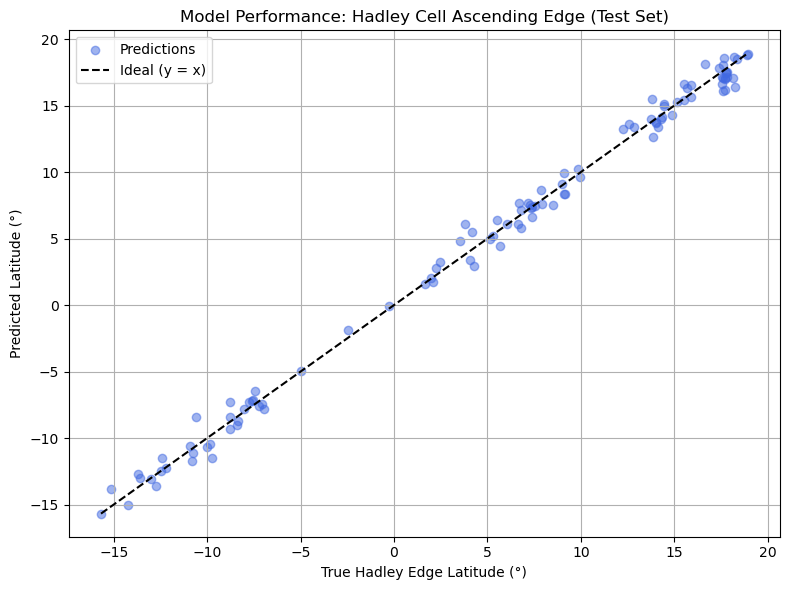

In [10]:
# 9. Evaluate on test set
print("Evaluating on test set...")
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        all_preds.append(y_pred.numpy())
        all_targets.append(y_batch.numpy())

preds = np.concatenate(all_preds).squeeze()
targets = np.concatenate(all_targets).squeeze()

# Unnormalize
preds_denorm = preds * labels_std + labels_mean
targets_denorm = targets * labels_std + labels_mean

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

mae = mean_absolute_error(targets_denorm, preds_denorm)
rmse = np.sqrt(mean_squared_error(targets_denorm, preds_denorm))
r2 = r2_score(targets_denorm, preds_denorm)

print(f"Test MAE:  {mae:.2f}° latitude")
print(f"Test RMSE: {rmse:.2f}° latitude")
print(f"Test R² Score: {r2:.3f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(targets_denorm, preds_denorm, alpha=0.5, color="royalblue", label="Predictions")
plt.plot([min(targets_denorm), max(targets_denorm)],
         [min(targets_denorm), max(targets_denorm)],
         'k--', label="Ideal (y = x)")
plt.xlabel("True Hadley Edge Latitude (°)")
plt.ylabel("Predicted Latitude (°)")
plt.title("Model Performance: Hadley Cell Ascending Edge (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def predict_hadley_edge(streamfunc_2d):
    """
    Predicts the Hadley cell ascending edge latitude given a new 2D stream function array.
    Input shape should be (level, lat), i.e., (37, 721).
    """
    assert streamfunc_2d.shape == (37, 721), "Input shape must be (37, 721)"

    # Load normalization stats
    stats = np.load("hadley_norm_stats.npz")
    input_mean = stats["input_mean"]
    input_std = stats["input_std"]
    label_mean = stats["label_mean"]
    label_std = stats["label_std"]

    # Normalize and reshape input
    streamfunc_2d_norm = (streamfunc_2d - input_mean) / input_std
    input_tensor = torch.tensor(streamfunc_2d_norm.reshape(1, -1), dtype=torch.float32)

    # Load model
    input_dim = 37 * 721
    model = HadleyNet(input_dim)
    model.load_state_dict(torch.load("hadley_model.pth"))
    model.eval()

    # Predict
    with torch.no_grad():
        pred_norm = model(input_tensor).item()
        pred_lat = pred_norm * label_std + label_mean

    return pred_lat

In [ ]:
# Predict edge for a single streamfunction
predicted_lat=predict_hadley_edge(ds.streamfunc.sel(time="2020-08-01").values)
plt.figure(figsize=(20, 10))
ds.streamfunc.sel(time="2020-08-01").plot.contourf(yincrease=False,levels=20)
labeled_lat = ds["hc_edge_shared"].sel(time="2020-08-01")
plt.axvline(labeled_lat, color = 'orange')
plt.axvline(predicted_lat, color = 'yellow')
print(f"Predicted lat = {predicted_lat:.2f}° latitude")
print(f"Labeled lat = {labeled_lat:.2f}° latitude")
